In [143]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from statsmodels.formula.api import ols
import statsmodels.api as sm
import pandas as pd

In [2]:
def read_from_txt(input_path):
    data = np.genfromtxt(input_path, delimiter=' ',
            dtype=[('source', 'U8'),
                ('sink', 'U8'), 
                ('score', 'f8'),
                ('class', 'i8')])
    return data

In [3]:
def _read_data(path):
    data = []
    for p in path:
        data.append(read_from_txt(p))

    features = np.array([d['score'] for d in data])
    labels = data[0]['class']

    combined_features = features[0]

    if features.shape[0] == 1:
        return combined_features.reshape(-1, 1), labels

    for f in features[1:]:
        combined_features = np.c_[combined_features, f]

    return combined_features, labels

In [241]:
data_path = [
    '../output/simrank/prop/simrank_clm_02.txt',
    '../output/propflow/prop/propflow_clm.txt',
    '../output/localpath/prop/localpath_clm_11.txt',
    
    
    '../output/jaccardneighbor/prop/jaccard_neighbor_clm_02.txt',
    '../output/jaccardneighbor/prop/jaccard_neighbor_inbound_clm_02.txt',
    
    '../output/consineneighbor/prop/consine_neighbor_inbound_clm.txt',
    
    '../output/friendmeasure/prop/friendmeasure_clm_03.txt',
    
    '../output/shortestpath/prop/shortestpath_clm_02.txt',
    
    '../output/outdegree/prop/outdegree_clm.txt',
    '../output/indegree/prop/indegree_clm.txt',
]

test_path = [
    '../output/simrank/simrank_test_clm_02.txt',
    '../output/propflow/propflow_test_clm.txt',
    '../output/localpath/localpath_test_clm_11.txt',
    
    
    '../output/jaccardneighbor/jaccard_neighbor_test_clm_02.txt',
    '../output/jaccardneighbor/jaccard_neighbor_inbound_test_clm_02.txt',
    '../output/consineneighbor/consine_neighbor_inbound_test_clm.txt',
    
    '../output/friendmeasure/friendmeasure_test_clm_03.txt',
    
    '../output/shortestpath/shortestpath_test_clm_02.txt',
    
    '../output/outdegree/outdegree_test_clm.txt',
    '../output/indegree/indegree_test_clm.txt',
]

features, labels = _read_data(data_path)
test_features, _ = _read_data(test_path)

In [243]:
# print(stats.ttest_rel(features[:, 5], features[:, 6]))

for i in range(0, len(test_path)):
    fe_1 = features[:, i]

    fe_2 = test_features[:, i]

    name = test_path[i].split('/')[2]
    print(np.mean(fe_1), np.mean(fe_2))
    print(f'{i + 1} -- p-value for {name}:', stats.ttest_ind(fe_2, fe_1).pvalue)
    print('\n')
    # d = np.c_[fe_2, fe_3]
    # plt.hist(d)
    # plt.show()

0.28329223200000003 0.27568576000000006
1 -- p-value for simrank: 0.21737707428781045


0.00030448648078152546 0.00022050444453299844
2 -- p-value for propflow: 0.11153282298401158


0.23223892000000004 0.22377500000000003
3 -- p-value for localpath: 0.34677770672784203


0.017621382064257667 0.017229076133867167
4 -- p-value for jaccardneighbor: 0.5651527125884062


0.012068221615526046 0.013201252431769677
5 -- p-value for jaccardneighbor: 0.057887721241631745


0.00022721888587799336 0.00022304052012073322
6 -- p-value for consineneighbor: 0.8896464519881283


0.1754903082951414 0.16854030339729098
7 -- p-value for friendmeasure: 0.04245868910626015


2.33185 2.3455
8 -- p-value for shortestpath: 0.6932541159776802


1177.9588 1358.66
9 -- p-value for outdegree: 0.30782207021222224


1819.7752 1805.3105
10 -- p-value for indegree: 0.9825337802922809




In [278]:
# 540, 199, 74, 0
high_features = features[:, 7][features[:, 8] > 540]
high_features = features[:, 7][features[:, 8] > 540]
print(high_features)
print(high_features[].size)

print(np.mean(features[:, 7]), np.mean(test_features[:, 7]))

[1. 4. 1. ... 1. 1. 1.]
5076
2.33185 2.3455


In [296]:
def build_features(features, labels, f_index, index, thresholds):
    fs, ls, gs = [], [], []
    for i, t in enumerate(thresholds):
        if i == 0:
            fs.append(features[:, f_index][(features[:, index] > t)])
            ls.append(labels[features[:, index] > t])
            gs.append(np.repeat(str(i), ls[i].size))
        else:
            fs.append(features[:, f_index][(features[:, index] > t) & (features[:, index] <= thresholds[i-1])])
            ls.append(labels[(features[:, index] > t) & (features[:, index] <= thresholds[i-1])])
            gs.append(np.repeat(str(i), ls[i].size))
        
    new_f = np.hstack(tuple(fs))
    new_l = np.hstack(tuple(ls))
    new_g = np.hstack(tuple(gs))
        
    return (new_f, new_l, new_g)


def anova(new_f, new_l, new_g):
    df = pd.DataFrame(data={'feature': new_f, 'label': new_l, 'group': new_g})
    formula = 'feature ~ C(group) + C(label) + C(group):C(label)'
    model = ols(formula, df).fit()
    aov_table = sm.stats.anova_lm(model, typ=3)
    print(aov_table)

thresholds = [540, 199, 74, 0]
for i in range(len(test_path) - 2):
    name = test_path[i].split('/')[2]
    print(name)
    new_f, new_l, new_g = build_features(features, labels, i, 8, thresholds)
    anova(new_f, new_l, new_g)
    print('\n')

simrank
                        sum_sq       df            F         PR(>F)
Intercept           194.381213      1.0  3278.958442   0.000000e+00
C(group)             31.188069      3.0   175.367398  3.114178e-112
C(label)             29.711047      1.0   501.186742  1.166589e-109
C(group):C(label)     4.132454      3.0    23.236374   5.225545e-15
Residual           1185.153544  19992.0          NaN            NaN


propflow
                         sum_sq       df           F        PR(>F)
Intercept          1.095509e-10      1.0    0.000022  9.962380e-01
C(group)           1.304144e-10      3.0    0.000009  1.000000e+00
C(label)           1.465669e-05      1.0    2.974383  8.460784e-02
C(group):C(label)  2.101479e-03      3.0  142.155842  3.810587e-91
Residual           9.851341e-02  19992.0         NaN           NaN


localpath
                        sum_sq       df            F         PR(>F)
Intercept            66.355426      1.0   582.971458  5.553410e-127
C(group)             30

In [231]:
print(np.corrcoef(features.T))
print('\n')
print(np.corrcoef(test_features.T))

[[ 1.          0.15744074  0.55357209  0.54505603  0.51888811  0.24772662
   0.59429671  0.04453241 -0.03345855]
 [ 0.15744074  1.          0.12595447  0.29216658  0.2281033   0.32582197
   0.12200431 -0.01944418  0.0167017 ]
 [ 0.55357209  0.12595447  1.          0.64196586  0.5711674   0.09010436
   0.31656484  0.15237516  0.01898592]
 [ 0.54505603  0.29216658  0.64196586  1.          0.75792409  0.39714653
   0.49309075  0.07381858 -0.03053302]
 [ 0.51888811  0.2281033   0.5711674   0.75792409  1.          0.44524697
   0.42877761  0.15795065 -0.02434278]
 [ 0.24772662  0.32582197  0.09010436  0.39714653  0.44524697  1.
   0.27362262 -0.02533707 -0.00320902]
 [ 0.59429671  0.12200431  0.31656484  0.49309075  0.42877761  0.27362262
   1.          0.07484691 -0.01697095]
 [ 0.04453241 -0.01944418  0.15237516  0.07381858  0.15795065 -0.02533707
   0.07484691  1.         -0.00774421]
 [-0.03345855  0.0167017   0.01898592 -0.03053302 -0.02434278 -0.00320902
  -0.01697095 -0.00774421  1. 

In [4]:
def read_train_file(input_path):
    """
    : param input_path: the path of train file
    : data format: source sink1 sink2 sink3
    """
    set_dict = {}

    with open(input_path) as reader:
        for r in reader:
            infos = r.split()
            set_dict[infos[0]] = set(infos[1:])
    
    return set_dict

In [5]:
set_dict = read_train_file('../data/train.txt')
inbound_dict = read_train_file('../output/inbound_collect.txt')

In [95]:
all_dict = read_train_file('../output/collect.txt')

In [45]:
print(2)

2


In [290]:
s1, s2, s3, s4 = [], [], [], []
t1, t2, t3, t4 = [], [], [], []

with open('../output/fakedataprop/fake_origin_kim.txt') as reader:
    for r in reader:
        source, sink, _ = r.split()
        s1.append(len(set_dict[source]))
        if sink in set_dict:
            s2.append(len(set_dict[sink]))
        t1.append(len(inbound_dict[source]))
        t2.append(len(inbound_dict[sink]))
        
        
with open('../output/test.txt') as reader:
    for r in reader:
        source, sink, _ = r.split()
        s3.append(len(set_dict[source]))
        if sink in set_dict:
            s4.append(len(set_dict[sink]))
        t3.append(len(inbound_dict[source]))
        t4.append(len(inbound_dict[sink]))

In [291]:
a1 = np.array(s1)
a2 = np.array(s2)
a3 = np.array(s3)
a4 = np.array(s4)

b1 = np.array(t1)
b2 = np.array(t2)
b3 = np.array(t3)
b4 = np.array(t4)

print('outbound source')
print(np.median(a1))
print(np.median(a3))
print(np.mean(a1))
print(np.mean(a3))
print('\n')

print('outbound sink')
print(np.median(a2))
print(np.median(a4))
print(np.mean(a2))
print(np.mean(a4))
print('\n')

print('inbound source')
print(np.median(b1))
print(np.median(b3))
print(np.mean(b1))
print(np.mean(b3))
print('\n')

print('inbound sink')
print(np.median(b2))
print(np.median(b4))
print(np.mean(b2))
print(np.mean(b4))
print('\n')

outbound source
173.0
161.0
1284.3779
1323.048


outbound sink
198.0
294.0
9429.536501714845
9602.715425531915


inbound source
38.0
36.0
94.4748
90.9115


inbound sink
27.0
33.0
145.36995
143.195




1081.3556533480023
1138.1650825412705


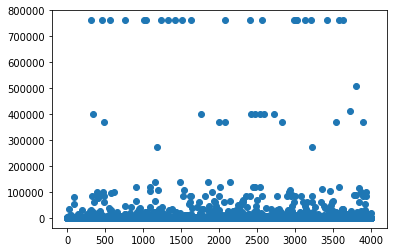

In [76]:
a3_clean = a3[a3!=max(a3)]
# plt.scatter(np.arange(a3_clean.size), a3_clean)
a1_clean = a1[a1<350000]
print(np.mean(a1_clean))
print(np.mean(a3_clean))
plt.scatter(np.arange(a2.size), a2)

In [160]:
t1, t2, t3, t4 = [], [], [], []


with open('../output/fakedataprop/fake_origin_kim.txt') as reader:
    for r in reader:
        source, sink, _ = r.split()
        t1.append(len(set_dict[source]))
        if sink in set_dict:
            t2.append(len(set_dict[sink]))
        else:
            t2.append(0)
        
with open('../output/test.txt') as reader:
    for r in reader:
        source, sink, _ = r.split()
        t3.append(len(set_dict[source]))
        if sink in set_dict:
            t4.append(len(set_dict[sink]))
        else:
            t4.append(0)

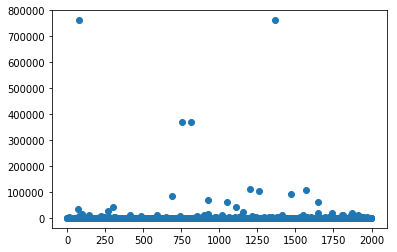

In [161]:
b1 = np.array(t1)
b2 = np.array(t2)
b3 = np.array(t3)
b4 = np.array(t4)

plt.scatter(np.arange(b4.size), b4)

In [162]:
with open('../output/fakedataprop/fake_origin_clm.txt') as reader:
    for r in reader:
        source, sink, label = r.split()
        if label == '1' and sink not in set_dict[source]:
            print('yes')
        if label == '0' and sink in set_dict[source]:
            print('abnormal')
    print('all done!')

all done!


In [97]:
features

array([[0.00000000e+00],
       [0.00000000e+00],
       [1.20031548e-07],
       ...,
       [2.38884198e-04],
       [6.49955889e-08],
       [0.00000000e+00]])

In [105]:
print(b2[features[:,0]>0.025])

[   0    0    0    0    0  292    0    0    0  508    0    0    0   18
    0    0  134 3168    0 1051    0    0]
